In [13]:
import webbrowser
import urllib

from pynput import keyboard
from pynput.mouse import Controller
import pyautogui

import numpy as np
import cv2
from PIL import Image

import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
def is_white(a):
    return (a == 255).all()

def cut_whitespace(c):
    c_flat = c[:,:,0]
    white_vert = np.apply_along_axis(is_white, 0, c_flat)
    white_horiz = np.apply_along_axis(is_white, 1, c_flat)
    pos_vert = np.argwhere(white_vert == False)
    pos_horiz = np.argwhere(white_horiz == False)
    return c[pos_horiz[0][0]:pos_horiz[-1][0], pos_vert[0][0]:pos_vert[-1][0],:]

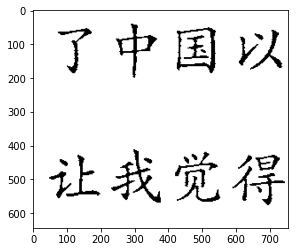

In [94]:
im = cv2.imread('c.png')
plt.imshow(im)

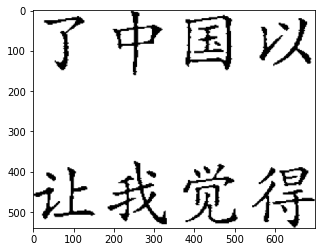

In [95]:
im_crop = cut_whitespace(im)
plt.imshow(im_crop)

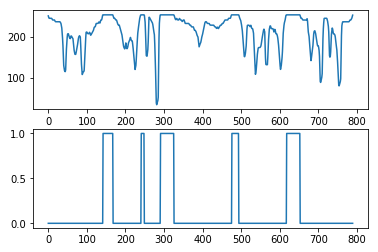

In [17]:
im_crop_flat = im_crop[:,:,0]
avg_vert = np.apply_along_axis(np.mean, 0, im_crop_flat)
thresh_vert = np.apply_along_axis(is_white, 0, im_crop_flat)
fig, ax = plt.subplots(2, 1)
ax[0].plot(avg_vert)
ax[1].plot(thresh_vert)

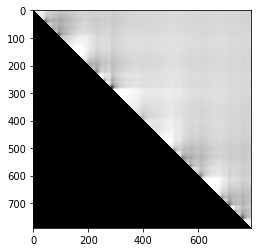

In [18]:
d = np.zeros((avg_vert.shape[0], avg_vert.shape[0]))
r = np.arange(avg_vert.shape[0])
for i in range(0, avg_vert.shape[0]):
    for j in range(i+1, avg_vert.shape[0]):
        d[i, j] = np.mean(avg_vert[i:j])
        
plt.imshow(d, cmap='gray')

[[142 168]
 [241 249]
 [291 326]
 [476 494]
 [618 653]]
[26  8 35 18 35]
[ True False  True  True  True]
[[  0 142]
 [168 291]
 [326 476]
 [494 618]
 [653 789]]
[142 123 150 124 136]
[ True  True  True  True  True]


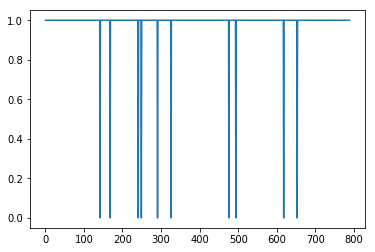

In [35]:
b = thresh_vert == np.roll(thresh_vert, 1)
plt.plot(b)
white_bounds = np.where(thresh_vert != np.roll(thresh_vert, 1))
white_bounds = np.apply_along_axis(lambda i: [white_bounds[0][i], white_bounds[0][i+1]], 0, np.arange(0, len(white_bounds[0]), 2)).transpose()
white_width = np.apply_along_axis(lambda i: i[1] - i[0], 1, white_bounds)
white_preserve = np.apply_along_axis(lambda i: (np.sum(white_width) - i)/(white_width.shape[0] - 1) < 2*i, 0, white_width)
print white_bounds
print white_width
print white_preserve
char_bounds = white_bounds[white_preserve].flatten()
char_bounds = np.insert(char_bounds, 0, 0)
char_bounds = np.append(char_bounds, thresh_vert.shape[0] - 1)
char_bounds = char_bounds.reshape((char_bounds.shape[0])/2, 2)
char_width = np.apply_along_axis(lambda i: i[1] - i[0], 1, char_bounds)
char_preserve = np.apply_along_axis(lambda i: (np.sum(char_width) - i)/(char_width.shape[0] - 1) < 4*i, 0, char_width)
print char_bounds
print char_width
print char_preserve
char_bounds = char_bounds[char_preserve]

In [105]:
def split(im, ax):
    im_crop = cut_whitespace(im)
    im_crop_flat = im_crop[:,:,0]
    thresh = np.apply_along_axis(is_white, ax, im_crop_flat)
    white_bounds = np.where(thresh != np.roll(thresh, 1))[0]
    if(len(white_bounds) == 0):
        return [im_crop]
    white_bounds = np.apply_along_axis(lambda i: [white_bounds[i], white_bounds[i+1]], 0, np.arange(0, len(white_bounds), 2)).transpose()
    white_width = np.apply_along_axis(lambda i: i[1] - i[0], 1, white_bounds)
    white_preserve = np.array([True]) if white_width.shape[0] == 1 else np.apply_along_axis(lambda i: (np.sum(white_width) - i)/(white_width.shape[0] - 1) < 2*i, 0, white_width)
    char_bounds = white_bounds[white_preserve].flatten()
    char_bounds = np.insert(char_bounds, 0, 0)
    char_bounds = np.append(char_bounds, thresh.shape[0] - 1)
    char_bounds = char_bounds.reshape((char_bounds.shape[0])/2, 2)
    char_width = np.apply_along_axis(lambda i: i[1] - i[0], 1, char_bounds)
    char_preserve = np.apply_along_axis(lambda i: (np.sum(char_width) - i)/(char_width.shape[0] - 1) < 4*i, 0, char_width)
    char_bounds = char_bounds[char_preserve]
    if ax == 0:
        chars = map(lambda i: cut_whitespace(im_crop[:, i[0]:i[1], :]), char_bounds)
    elif ax == 1:
        chars = map(lambda i: cut_whitespace(im_crop[i[0]:i[1], :, :]), char_bounds)
    return chars

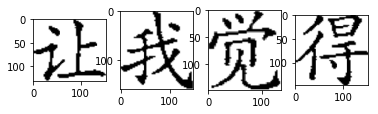

In [108]:
chars = split(im, 1)
for i in range(0, len(chars)):
    chars[i] = split(chars[i], 0)
    
    
fig, ax = plt.subplots(1, len(chars[1]))
for i in range(0, len(chars[1])):
    ax[i].imshow(chars[1][i])